In [69]:
import pandas as pd
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer


from sklearn.model_selection import KFold,StratifiedKFold
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot  as plt

#http://localhost:8888/lab/workspaces/auto-O/tree/MyQuantFinProject/LearnDataSC/Prasertcbs_ML/sklearn_feature_importances_with_treeclassifier.ipynb
#http://localhost:8888/lab/workspaces/auto-C/tree/MyQuantFinProject/LearnDataSC/Prasertcbs_ML/sklearn_classification_iris2.ipynb

In [59]:
dateTimeCols=['open_datetime','response_datetime','resolved_datetime','close_datetime']

cateFeatures=['product_type','brand','incident_type','service_type','is_failure_type','sla']
numericFeatures=['count_detail','open_to_close_hour','response_to_resolved_hour','open_to_response_hour','resolved_to_close_hour']

colLabel='severity_label'

colFeatures=cateFeatures+numericFeatures
cols=[colLabel]+colFeatures
print(cols)


isAutomaticOneHotByColumnTransformer=False
isManualEncoding=True
 


to_date='2023-12-31'

['severity_label', 'product_type', 'brand', 'incident_type', 'service_type', 'is_failure_type', 'sla', 'count_detail', 'open_to_close_hour', 'response_to_resolved_hour', 'open_to_response_hour', 'resolved_to_close_hour']


# Load and Prepare Data

In [60]:
df_incident = pd.read_csv('incident_data.csv',parse_dates=dateTimeCols)
print(f"Incident From {df_incident['open_datetime'].min()} To {df_incident['open_datetime'].max()}")
df_incident=df_incident.query("open_datetime<=@to_date")
df_incident=df_incident[cols]
print(df_incident.info())
df_incident.tail()



Incident From 2020-03-15 13:36:00 To 2023-02-01 06:40:00
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2094 entries, 0 to 2093
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   severity_label             2094 non-null   object 
 1   product_type               2094 non-null   object 
 2   brand                      2094 non-null   object 
 3   incident_type              2094 non-null   object 
 4   service_type               2094 non-null   object 
 5   is_failure_type            2094 non-null   bool   
 6   sla                        2094 non-null   object 
 7   count_detail               2094 non-null   int64  
 8   open_to_close_hour         2094 non-null   float64
 9   response_to_resolved_hour  2094 non-null   float64
 10  open_to_response_hour      2094 non-null   float64
 11  resolved_to_close_hour     2094 non-null   float64
dtypes: bool(1), float64(4), int64(1), object(6)
mem

,severity_label,product_type,brand,incident_type,service_type,is_failure_type,sla,count_detail,open_to_close_hour,response_to_resolved_hour,open_to_response_hour,resolved_to_close_hour
2089,Minor,Storage,YIP,General Incident,Request,False,24x7 6Hrs Resolution Time,1,67.250000,0.000000,67.250000,0.000000
2090,Major,Storage,NetApp,General Incident,Incident,False,24x7 4Hrs Response Time,3,365.316667,169.016667,2.633333,193.666667
2091,Major,Storage,NetApp,General Incident,Incident,False,24x7 4Hrs Response Time,2,20.166667,4.533333,0.550000,15.083333
2092,Major,Storage,NetApp,General Incident,Incident,False,24x7 4Hrs Response Time,1,23.783333,0.000000,23.783333,0.000000
2093,Major,Storage,NetApp,General Incident,Incident,False,24x7 4Hrs Response Time,2,31.150000,28.466667,1.450000,1.233333


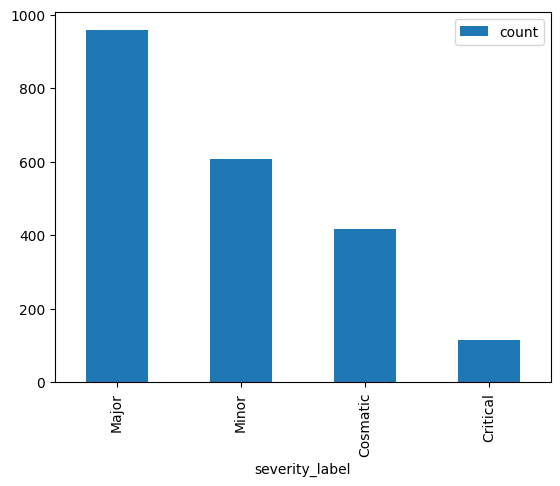

,count
severity_label,
Major,958
Minor,606
Cosmatic,416
Critical,114


In [61]:
dfLabel=df_incident.groupby([colLabel]).size().to_frame('count').sort_values(by='count',ascending=False)
dfLabel.plot(kind='bar')
plt.show()
dfLabel

# Process features and class

In [62]:
# cate_features=[ col for col in features if  col not in numericFeatures ]
if isAutomaticOneHotByColumnTransformer==False:
    
    if isManualEncoding==False:
        print("Let XGBoost encode itself")
    else:
        print("Encode by  LabelEncoder")
    features=[ col for col in list(df_incident.columns) if  col!=colLabel ]
    X = df_incident.loc[:,features]
    for cate_col in cateFeatures:
        if isManualEncoding==False:
              X[cate_col]=X[cate_col].astype("category")             
        else:  
            cateFeatEncoder = LabelEncoder()
            X[cate_col]=cateFeatEncoder.fit_transform(X[cate_col])

else:
        categorical_transformer = OneHotEncoder(sparse_output=False, handle_unknown="ignore")
        ct = ColumnTransformer(transformers=[("cat", categorical_transformer,cateFeatures )],remainder='passthrough')
        ct.set_output(transform='pandas')
        X = ct.fit_transform(df_incident)
        colLabel=f"remainder__{colLabel}"
        print(f"{colLabel} :OneHot Encoding to Fetures by ColumnTransformer")
        


Encode by  LabelEncoder


In [63]:
print(X.info())
X.tail()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2094 entries, 0 to 2093
Data columns (total 11 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   product_type               2094 non-null   int32  
 1   brand                      2094 non-null   int32  
 2   incident_type              2094 non-null   int32  
 3   service_type               2094 non-null   int32  
 4   is_failure_type            2094 non-null   int64  
 5   sla                        2094 non-null   int32  
 6   count_detail               2094 non-null   int64  
 7   open_to_close_hour         2094 non-null   float64
 8   response_to_resolved_hour  2094 non-null   float64
 9   open_to_response_hour      2094 non-null   float64
 10  resolved_to_close_hour     2094 non-null   float64
dtypes: float64(4), int32(5), int64(2)
memory usage: 155.4 KB
None


,product_type,brand,incident_type,service_type,is_failure_type,sla,count_detail,open_to_close_hour,response_to_resolved_hour,open_to_response_hour,resolved_to_close_hour
2089,7,19,7,1,0,2,1,67.250000,0.000000,67.250000,0.000000
2090,7,10,7,0,0,1,3,365.316667,169.016667,2.633333,193.666667
2091,7,10,7,0,0,1,2,20.166667,4.533333,0.550000,15.083333
2092,7,10,7,0,0,1,1,23.783333,0.000000,23.783333,0.000000
2093,7,10,7,0,0,1,2,31.150000,28.466667,1.450000,1.233333


In [64]:
if isAutomaticOneHotByColumnTransformer==False:
    Y = df_incident.loc[:,[colLabel]]
    Y[colLabel]=Y[colLabel].astype("category")

    
else:
    Y=X.pop(colLabel)
    # # X=X.pop(colLabel)

    print(Y.info())
Y[:5]

,severity_label
0,Major
1,Major
2,Major
3,Minor
4,Major


# Encode string class values as integers

In [65]:
label_encoder = LabelEncoder()
ylabelEncoded = label_encoder.fit_transform(Y)

print(label_encoder.classes_)

print(ylabelEncoded[-5:])

['Cosmatic' 'Critical' 'Major' 'Minor']
[3 2 2 2 2]


D:\ProgramData\Anaconda3\envs\dev_ml_local\lib\site-packages\sklearn\preprocessing\_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


# Split Train and Test Data

In [66]:
seed = 7
test_size = 0.15
X_train, X_test, y_train, y_test = train_test_split(X, ylabelEncoded, test_size=test_size, random_state=seed)
print(X_train.shape,X_test.shape)
print(y_train.shape,y_test.shape)

print("---------------------------------------------------------------------------------------")
print(y_train[:5])
X_train[:5]



(1779, 11) (315, 11)
(1779,) (315,)
---------------------------------------------------------------------------------------
[0 2 2 2 2]


,product_type,brand,incident_type,service_type,is_failure_type,sla,count_detail,open_to_close_hour,response_to_resolved_hour,open_to_response_hour,resolved_to_close_hour
1226,6,16,4,1,0,0,1,3.000000,2.983333,0.016667,0.0
544,5,7,7,0,0,3,1,11.833333,11.833333,0.000000,0.0
1157,0,2,7,0,0,0,1,1.000000,1.000000,0.000000,0.0
1042,5,7,7,0,0,0,1,6.850000,6.666667,0.183333,0.0
194,2,12,8,0,0,0,1,52.000000,47.750000,0.250000,4.0


# RandomForest

In [67]:
model_rf = RandomForestClassifier()  

model_rf.fit(X_train, y_train)

y_pred_rf = model_rf.predict(X_test)
predictions_rf = [round(value) for value in y_pred_rf]

accuracy_rf = accuracy_score(y_test, predictions_rf)
print("RandomForest Accuracy: %.2f%%" % (accuracy_rf * 100.0))

RandomForest Accuracy: 80.00%


# XGBoost 

In [68]:
# Supported tree methods are `gpu_hist`, `approx`, and `hist`.
if isManualEncoding==True or isAutomaticOneHotByColumnTransformer==True:
    print("XGBClassifier()")
    model_xg = XGBClassifier()
else:
   print("XGBClassifier(enable_categorical=True,tree_method=hist)")
   model_xg = XGBClassifier(enable_categorical=True,tree_method="hist")

# print(model_xg)
model_xg.fit(X_train, y_train)

y_pred_xg = model_xg.predict(X_test)
predictions_xg = [round(value) for value in y_pred_xg]

accuracy_xg = accuracy_score(y_test, predictions_xg)
print("XGBoost Accuracy: %.2f%%" % (accuracy_xg * 100.0))

XGBClassifier()
XGBoost Accuracy: 78.73%


# Feature Important

service_type                 0.534350
is_failure_type              0.071407
brand                        0.061659
product_type                 0.054416
resolved_to_close_hour       0.051134
count_detail                 0.051083
sla                          0.050865
incident_type                0.034926
open_to_response_hour        0.031893
response_to_resolved_hour    0.031725
open_to_close_hour           0.026540
dtype: float32


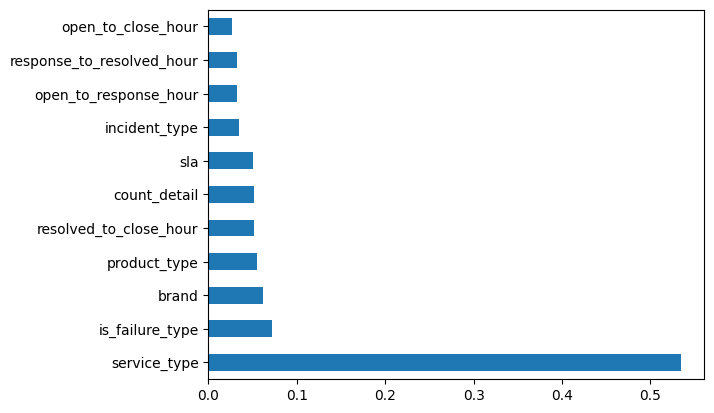

In [71]:
feature_series=pd.Series(model_xg.feature_importances_, index=X.columns).sort_values(ascending=False)
print(feature_series)
feature_series.plot(kind='barh')
plt.show()

service_type                 0.178898
open_to_close_hour           0.138013
response_to_resolved_hour    0.129936
open_to_response_hour        0.127869
brand                        0.091057
incident_type                0.084440
count_detail                 0.067623
product_type                 0.066609
resolved_to_close_hour       0.060911
sla                          0.048913
is_failure_type              0.005731
dtype: float64


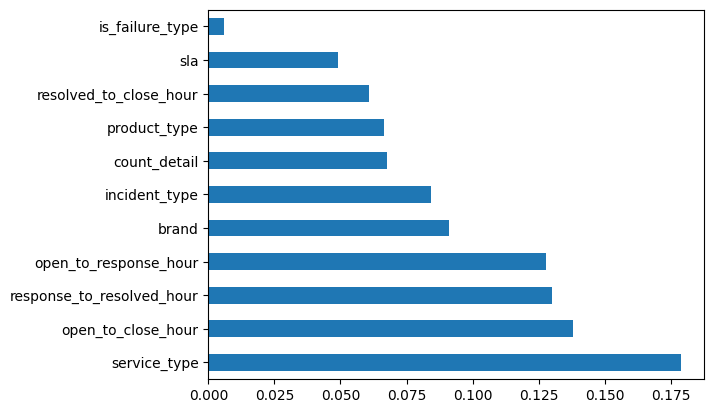

In [72]:
feature_series=pd.Series(model_rf.feature_importances_, index=X.columns).sort_values(ascending=False)
print(feature_series)
feature_series.plot(kind='barh')
plt.show()